####  Junhong Kim
- Ph.D. Candidate in Industrial Management Engineering
- Korea University, Seoul, Republic of Korea
- Mobile Phone  +82 10 3099 3004
- LinkedIn      http://ca.linkedin.com/in/charcoalgrey
- E-mail        junhongkim@korea.ac.kr

# 간단하게 직접 만든 Sine Dataset을 기반으로 1D CAM을 
# 실습해 보고 결과를 해석해 봅니다
#### 본 시간은 가장 Toy dataset인 Sine, Noise Sine dataset을 이용한다
#### 1-D convolution을 실습해 보며, 마지막 단에 GAP(Global average pooling을 통한)
#### Class Activation Map을 실습해 본다.

In [1]:
%matplotlib inline
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'
import tensorflow as tf
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)

C:\ProgramData\Anaconda3\envs\lab2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## [1] 파일을 불러오기 위해서 파일이 있는 폴더로 이동하도록 path를 잡는다
####  os.path.join 함수는 폴더 구조로 주소를 연결시켜주는 함수이다

In [2]:
Data_Path = os.path.join(os.getcwd(),"Dataset","CNN","Classification","Toy_Sine")

## [2] 데이터를 불러와서 Partition 해보자

In [3]:
Raw_Data=np.load(os.path.join(Data_Path+"/Toy_Dataset_Sine.npy"))
# 크기 확인 / 100개의 시계열 데이터와 2개의 target(Dummy variable)을 가지고 있다.
print(np.shape(Raw_Data))

(32000, 102)


In [4]:
#이제 7:3으로 data partition을 해보도록 하자.
def Data_Partition(Data,Train_Ratio,Target_Column):
    Full_Index = np.arange((np.shape(Data)[0]))
    np.random.seed(777)
    np.random.shuffle(Full_Index)
    Raw_Data2=Raw_Data[Full_Index]

    Train_Data = Raw_Data2[:np.int((np.floor(np.shape(Data)[0]*Train_Ratio)))]
    Test_Data = Raw_Data2[np.int((np.floor(np.shape(Data)[0]*Train_Ratio))):]
    Train_Target = Train_Data[:,Target_Column]
    Test_Target = Test_Data[:,Target_Column]
    Train_Input = Train_Data[:,:Target_Column[0]]
    Test_Input = Test_Data[:,:Target_Column[0]]
    return(Train_Input,Train_Target,Test_Input,Test_Target) # end function

Train_Input,Train_Target,Test_Input,Test_Target = Data_Partition(Raw_Data,0.7,range(100,102))

# shape를 다시 한번 확인 하도록 하자. (확인차)
print('------------------------------\n'+
'     Check of Dataset Size! \n'+
'------------------------------\n'+
"Train_Input_Size : %s" % (np.shape(Train_Input),) + '\n'+
"Test_Input_Size : %s" % (np.shape(Test_Input),) + '\n'+
"Train_Target_Size : %s" % (np.shape(Train_Target),) + '\n'+
"Train_Target_Size : %s" % (np.shape(Test_Target),))


------------------------------
     Check of Dataset Size! 
------------------------------
Train_Input_Size : (22400, 100)
Test_Input_Size : (9600, 100)
Train_Target_Size : (22400, 2)
Train_Target_Size : (9600, 2)


## [3] 셈플을 가져와서 어떤 데이터셋인지 확인해 보자

In [5]:
Normal_Sample=np.where(Train_Target[:,0]==1)[0][:1]
Abnormal_Sample=np.where(Train_Target[:,0]==0)[0][:1]

def Sample_Plot(Data):
    for i in range(len(Data)):        
        plt.figure(figsize=(20,5))
        plt.subplot(111+i)
        plt.plot(Train_Input[Data[i],...])

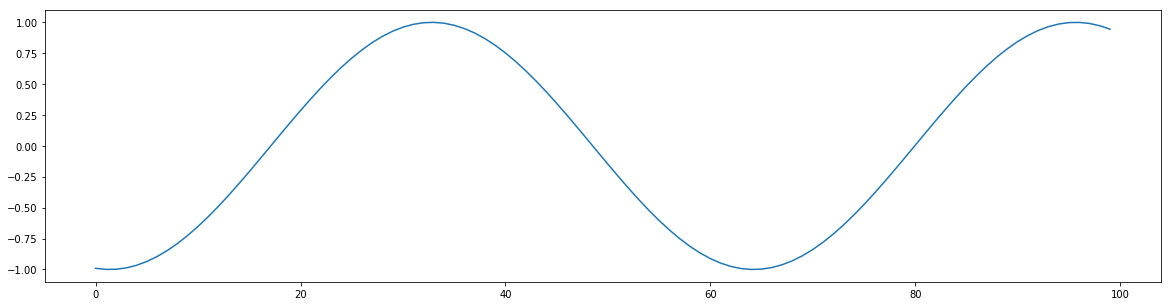

In [6]:
Sample_Plot(Normal_Sample)

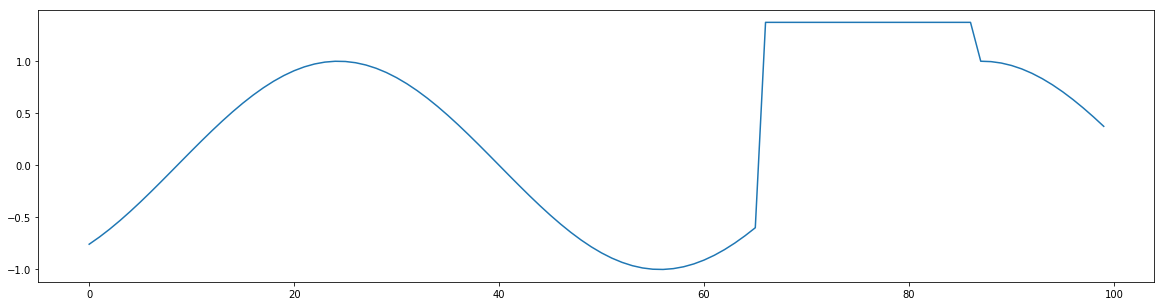

In [7]:
Sample_Plot(Abnormal_Sample)

## [4] 이제 1D convolution을 진행하고 CAM까지 진행해 보도록 하자

In [8]:
input_height = 1 # 1D-shape (1)
input_width = 100 # 1D-shape (2)
num_labels = 2
num_channels = 1
Train_Input=Train_Input.reshape(np.shape(Train_Input)[0],input_height,input_width,num_channels)
Test_Input=Test_Input.reshape(np.shape(Test_Input)[0],input_height,input_width,num_channels)
# shape를 다시 한번 확인 하도록 하자. (확인차)
print('------------------------------\n'+
'     Check of Dataset Size! \n'+
'------------------------------\n'+
"Train_Input_Size : %s" % (np.shape(Train_Input),) + '\n'+
"Test_Input_Size : %s" % (np.shape(Test_Input),) + '\n'+
"Train_Target_Size : %s" % (np.shape(Train_Target),) + '\n'+
"Train_Target_Size : %s" % (np.shape(Test_Target),))
#########################################################

------------------------------
     Check of Dataset Size! 
------------------------------
Train_Input_Size : (22400, 1, 100, 1)
Test_Input_Size : (9600, 1, 100, 1)
Train_Target_Size : (22400, 2)
Train_Target_Size : (9600, 2)


In [9]:
def bias_variable(shape):
    return tf.Variable(np.tile([0.01],shape),dtype=tf.float32)

def apply_max_pool(x, kernel_size, stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1],
                          strides=[1, 1, stride_size, 1], padding='VALID')

# define He initialization function
def He_Init(K_W, K_H, I_F, O_F):
    return tf.Variable(tf.truncated_normal([K_W, K_H, I_F, O_F], stddev=1, mean=0) /
                       (tf.sqrt(K_W * K_H * I_F / 2)), dtype=tf.float32)

In [11]:
# Placeholder setting
X = tf.placeholder(tf.float32, [None, np.shape(Train_Input)[1],np.shape(Train_Input)[2],np.shape(Train_Input)[3]])
Y = tf.placeholder(tf.float32, [None,2])
Learning_Rate = tf.placeholder(tf.float32)
train_bool = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32)
print("PlaceHolder complete!")

PlaceHolder complete!


In [13]:
with tf.name_scope('Conv_1_Set'):
    # Before Encoder Cell convolution
    Weight1 = He_Init(1, 3, np.shape(Train_Input)[3], 128)
    Bias1 = bias_variable(128)
    After_Conv1 = tf.nn.relu(
        tf.layers.batch_normalization(tf.add(tf.nn.conv2d(X, Weight1, strides=[1, 1, 1, 1], padding='SAME'),Bias1), momentum=0.9,
                                      training=train_bool),name="Conv1")

    Weight2 = He_Init(1, 3, 128, 128)
    Bias2 = bias_variable(128)
    After_Conv2 = tf.nn.relu(
        tf.layers.batch_normalization(tf.add(tf.nn.conv2d(After_Conv1, Weight2, strides=[1, 1, 1, 1], padding='SAME'),Bias2),
                                      momentum=0.9, training=train_bool),name="Conv2")

    After_Conv2_Pool = apply_max_pool(After_Conv2, 2, 2)

In [14]:
with tf.name_scope('Conv_2_Set'):
    Weight3 = He_Init(1, 3, 128, 256)
    Bias3 = bias_variable(256)
    After_Conv3 = tf.nn.relu(
        tf.layers.batch_normalization(tf.add(tf.nn.conv2d(After_Conv2_Pool, Weight3, strides=[1, 1, 1, 1], padding='SAME'),Bias3), momentum=0.9,
                                      training=train_bool),name="Conv3")
    Weight4 = He_Init(1, 3,256, 256)
    Bias4 = bias_variable(256)
    After_Conv4 = tf.nn.relu(
        tf.layers.batch_normalization(tf.add(tf.nn.conv2d(After_Conv3, Weight4, strides=[1, 1, 1, 1], padding='SAME'),Bias4),
                                      momentum=0.9, training=train_bool),name="Conv4")

#### [Q] GAP를 Kernel 사이즈 크기 없이 어떻게 할 수 있을까?

In [15]:
with tf.name_scope('Global_Avg_Pooling'):
####################################################################################################################
##### Average Pooling
####################################################################################################################
    TKS=After_Conv4.get_shape().as_list()[2] # The Kernel Size for Global average pooling
    Global_Avg_Pool=tf.nn.avg_pool(After_Conv4,[1,TKS,TKS,1],[1,TKS,TKS,1],padding='SAME',name='Average_Pool')
    shape = Global_Avg_Pool.get_shape().as_list()
    c_flat = tf.reshape(Global_Avg_Pool, [-1, shape[1] * shape[2] * shape[3]])

In [16]:
with tf.name_scope('FC_Network'):
    Conv1x1_W = He_Init(1, 1, 256, 2)
    After_Conv1x1 = tf.nn.conv2d(Global_Avg_Pool, Conv1x1_W, strides=[1, 1, 1, 1], padding='SAME')
    Conv1x1_Bias = bias_variable(2)
    Logits = tf.reshape(After_Conv1x1 + Conv1x1_Bias,[-1, 2])

In [17]:
with tf.name_scope('Opt'):
    Real_Softmax=tf.nn.softmax(Logits)
    Index_Max = tf.argmax(Real_Softmax, axis=1)
    SoftMax=tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Logits)
    loss = tf.reduce_mean(SoftMax)
    tf.summary.scalar('Loss', loss)
    # optimizer
    optimizer = tf.train.RMSPropOptimizer(Learning_Rate)
    train = optimizer.minimize(loss)
    # Session start
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    # Append batch_norm parameter during training step
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    print("Optimization method complete!")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Optimization method complete!


In [18]:
# train / RMSPROP
# Summary 정의
Tensorboard_Root_Path = os.getcwd()+"/Tensorboard/CAM_1D_sine/"
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(Tensorboard_Root_Path + '/train', sess.graph)
test_writer = tf.summary.FileWriter(Tensorboard_Root_Path + '/test')
print("Session Ready! & Let's Train!")

Session Ready! & Let's Train!


In [19]:
batch_size=32
Num_of_Iterlation_Based_On_Epoch=np.shape(Train_Input)[0]//batch_size
Num_of_Epoch=10

for z in range(Num_of_Epoch):
    for i in range(Num_of_Iterlation_Based_On_Epoch):
        TR_Index = np.random.choice(np.shape(Train_Input)[0], 32, replace=False)
        _, __ = sess.run([train, extra_update_ops],
                         feed_dict={X: Train_Input[TR_Index, :, :, :],
                                    Y: Train_Target[TR_Index,:],
                                    Learning_Rate: 0.0001, train_bool: True,
                                    keep_prob: 0.5})
        if (i % 10 == 0):
            TR_Index = np.random.choice(np.shape(Train_Input)[0], 32, replace=False)
            summary_tr = sess.run(merged,
                                  feed_dict={X: Train_Input[TR_Index, :, :, :],
                                             Y: Train_Target[TR_Index,:],
                                             Learning_Rate: 0.0001, train_bool: False,
                                             keep_prob: 1})

            TE_Index = np.random.choice(np.shape(Test_Input)[0], 32, replace=False)
            summary_te = sess.run(merged,
                                  feed_dict={X: Test_Input[TE_Index, :, :, :],
                                             Y: Test_Target[TE_Index,:],
                                             Learning_Rate: 0.0001, train_bool: False,
                                             keep_prob: 1})

            train_writer.add_summary(summary_tr, z*Num_of_Iterlation_Based_On_Epoch+i)
            test_writer.add_summary(summary_te, z*Num_of_Iterlation_Based_On_Epoch+i)
            #print(z*Num_of_Iterlation_Based_On_Epoch+i)
    print("Epoch:"+str(z+1))

Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10


In [20]:
def Visualization(Label,View):
    
    TE_Index = np.random.choice(np.where(Test_Target[:, 1] == Label)[0], 1, replace=False)
    ActivationMap, Linear_Comb_Weight, Prob_Hat,Train_Bias = sess.run([After_Conv4, Conv1x1_W,Real_Softmax,Conv1x1_Bias], feed_dict={X: Test_Input[TE_Index, :, :, :],
                                                                                      Y: Test_Target[TE_Index, :],
                                                                                      Learning_Rate: 0.00001,
                                                                                      train_bool: False,
                                                                                      keep_prob: 1})
    
    Reshape_Act_Map=np.reshape(ActivationMap,[50,256])
    Act_Weights = np.reshape(Linear_Comb_Weight[:,:,:,View], [256])
    Act_Bias = Train_Bias[View]
    
    
    
    
    
    CAM_Results_Prior=list()
    for  i in range(np.shape(Reshape_Act_Map)[1]):
        CAM_Results_Prior.append((Reshape_Act_Map)[:,i]*Act_Weights[i]+Act_Bias)
    First_CAM=np.sum(CAM_Results_Prior,axis=0)
    
    Test_Value=Test_Target[TE_Index, :]    
    
    
    if(Test_Value[0][0]==0):
        Real_Label='Bad'
    else:
        Real_Label='Good'
    Info_Label ='Label : '+Real_Label
    Info_Prob ='prob_Good : '+str(np.round(Prob_Hat[0][0]))+", "'prob_Bad : '+str(np.round(Prob_Hat[0][1]))
    
    plt.figure(figsize=(10, 6))
        
    x = range(100)
    y = np.reshape(Test_Input[TE_Index, :, :, :],100)
    x2 = range(50)
    y2 = First_CAM
    
    for i in np.arange(2):
        plt.title(Info_Label+ "   /   " + Info_Prob)
        plt.subplot(2, 1, i + 1)
        if (i == 0):            
            plt.plot(x, y)            
        if (i == 1):            
            plt.plot(x2, y2)

## Class activation map을 확인해 보자!
### Case 1 : 불량 데이터 중에서 불량 부분 보기

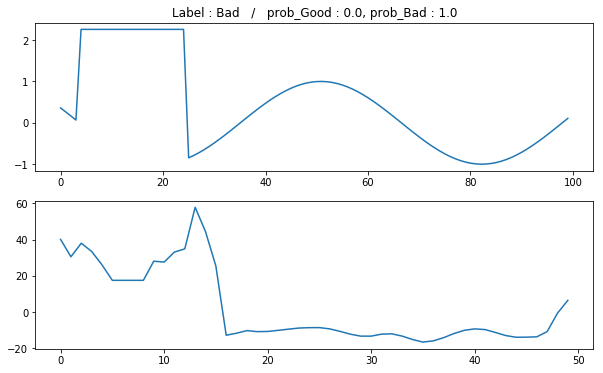

In [21]:
for iter in range(1):
    Visualization(1,1)

## Class activation map을 확인해 보자!
### Case 2 : 불량 데이터 중에서 정상 부분 보기

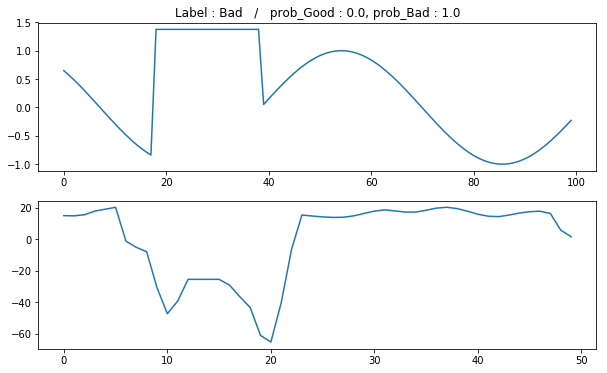

In [22]:
for iter in range(1):
    Visualization(1,0)

### 쉬운 데이터이므로 모두 정분류함

In [23]:
#Final Inference
Iter=np.shape(Test_Input)[0]/100
Output_List=list()
for ii in range(int(Iter)):
    Index=range(0+(100*ii),(100*(ii+1)))
    Output = sess.run(Index_Max,
                          feed_dict={X: Test_Input[Index,...],
                                     Y: Test_Target[Index],
                                     Learning_Rate: 0.0001, train_bool: False,
                                     keep_prob: 1})
    Output_List.append(Output)    
Y_Hat=np.concatenate(Output_List,axis=0)
Test_Accuracy=np.sum((Test_Target[:,0]==((Y_Hat-1)*-1)))/np.shape(Y_Hat)[0]
print("Test Accuracy : "+ str(Test_Accuracy))

Test Accuracy : 1.0
